The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Treinamento em Várias GPUs
:label:`sec_multi_gpu`

Até agora, discutimos como treinar modelos de forma eficiente em CPUs e GPUs. Nós até mostramos como frameworks de aprendizado profundo como MXNet (e TensorFlow) permitem paralelizar computação e comunicação automaticamente entre elas em :numref:`sec_auto_para`. Por último, mostramos em :numref:`sec_use_gpu` como listar todas as GPUs disponíveis em um computador usando `nvidia-smi`. O que *não* discutimos é como realmente paralelizar o treinamento de aprendizado profundo (omitimos qualquer discussão de *inferência* em várias GPUs aqui, pois é um tópico raramente usado e avançado que vai além do escopo deste livro). Em vez disso, sugerimos que, de alguma forma, seria possível dividir os dados em vários dispositivos e fazê-los funcionar. A presente seção preenche os detalhes e mostra como treinar uma rede em paralelo ao começar do zero. Detalhes sobre como tirar proveito da funcionalidade do Gluon são relegados a :numref:`sec_multi_gpu_concise`. Assumimos que o leitor está familiarizado com algoritmos SGD de minibatch, como os descritos em :numref:`sec_minibatch_sgd`.

## Dividindo o Problema

Vamos começar com um problema de visão computacional simples e uma rede ligeiramente arcaica, por exemplo, com várias camadas de convoluções, agrupamento e, possivelmente, algumas camadas densas no final. Ou seja, vamos começar com uma rede que se parece bastante com LeNet :cite:`LeCun.Bottou.Bengio.ea.1998` ou AlexNet :cite:`Krizhevsky.Sutskever.Hinton.2012`. Dadas várias GPUs (2 se for um servidor de desktop, 4 em um g4dn.12xlarge, 8 em um AWS p3.16xlarge, ou 16 em um p2.16xlarge), queremos particionar o treinamento de maneira a obter uma boa aceleração enquanto beneficiando simultaneamente de opções de design simples e reproduzíveis. Afinal, várias GPUs aumentam a capacidade de *memória* e *computação*. Em suma, temos várias opções, dado um minibatch de dados de treinamento que desejamos classificar.

* Podemos particionar as camadas de rede em várias GPUs. Ou seja, cada GPU recebe como entrada os dados que fluem para uma camada específica, processa os dados em várias camadas subsequentes e, em seguida, envia os dados para a próxima GPU.
    * Isso nos permite processar dados com redes maiores, em comparação com o que uma única GPU poderia suportar.
    * A pegada de memória por GPU pode ser bem controlada (é uma fração da pegada total da rede)
    * A interface entre as camadas (e, portanto, as GPUs) requer uma sincronização rígida. Isso pode ser complicado, especialmente se as cargas de trabalho computacionais não forem correspondidas adequadamente entre as camadas. O problema é agravado por um grande número de GPUs.
    * A interface entre as camadas requer grandes quantidades de transferência de dados (ativações, gradientes). Isso pode sobrecarregar a largura de banda dos barramentos da GPU.
    * Computação intensiva, mas operações sequenciais não são triviais para particionar. Veja, por exemplo, :cite:`Mirhoseini.Pham.Le.ea.2017` para um melhor esforço a este respeito. Continua sendo um problema difícil e não está claro se é possível obter uma boa escala (linear) em problemas não triviais. Não o recomendamos, a menos que haja um excelente suporte de estrutura / sistema operacional para encadear várias GPUs.
* Podemos dividir o trabalho necessário em camadas individuais. Por exemplo, em vez de computar 64 canais em uma única GPU, poderíamos dividir o problema em 4 GPUs, cada uma gerando dados para 16 canais. Da mesma forma, para uma camada densa, poderíamos dividir o número de neurônios de saída. :numref:`fig_alexnet_original` ilustra este design. A figura foi tirada de :cite:`Krizhevsky.Sutskever.Hinton.2012` onde esta estratégia foi usada para lidar com GPUs que tinham uma pegada de memória muito pequena (2 GB na época).
    * Isso permite um bom dimensionamento em termos de computação, desde que o número de canais (ou neurônios) não seja muito pequeno.
    * Várias GPUs podem processar redes cada vez maiores, uma vez que a memória disponível é dimensionada linearmente.
    * Precisamos de um número *muito grande* de operações de sincronização / barreira, pois cada camada depende dos resultados de todas as outras camadas.
    * A quantidade de dados que precisa ser transferida é potencialmente ainda maior do que ao distribuir camadas entre GPUs. Não recomendamos esta abordagem devido ao seu custo de largura de banda e complexidade.
    
![Paralelismo de modelo no design AlexNet original devido à memória GPU limitada.](../img/alexnet-original.svg)
:label:`fig_alexnet_original`
    

* Por último, podemos particionar os dados em várias GPUs. Desta forma, todas as GPUs realizam o mesmo tipo de trabalho, embora em observações diferentes. Os gradientes são agregados entre as GPUs após cada minibatch.
    * Esta é a abordagem mais simples e pode ser aplicada em qualquer situação.
    * Adicionar mais GPUs não nos permite treinar modelos maiores.
    * Só precisamos sincronizar após cada minibatch. Dito isso, é altamente desejável começar a trocar parâmetros de gradientes enquanto outros ainda estão sendo calculados.
    * Um grande número de GPUs leva a tamanhos de minibatch muito grandes, reduzindo assim a eficiência do treinamento.

Em geral, o paralelismo de dados é a maneira mais conveniente de proceder, desde que tenhamos acesso a GPUs com memória suficientemente grande. Veja também: cite: `Li.Andersen.Park.ea.2014` para uma descrição detalhada do particionamento para treinamento distribuído. A memória da GPU costumava ser um problema nos primeiros dias do *deep learning*. Até agora, esse problema foi resolvido para todos, exceto os casos mais incomuns. Nos concentramos no paralelismo de dados a seguir.


## Paralelismo de Dados

Suponha que haja $k$ GPUs em uma máquina. Dado o modelo a ser treinado, cada GPU manterá um conjunto completo de parâmetros do modelo de forma independente. O treinamento prossegue da seguinte maneira (consulte :numref:`fig_data_parallel`  para obter detalhes sobre o treinamento paralelo de dados em duas GPUs).

![Cálculo do gradiente estocástico de minibatch usando paralelismo de dados e duas GPUs.](../img/data-parallel.svg)
:label:`fig_data_parallel`

* Em qualquer iteração de treinamento, dado um minibatch aleatório, dividimos os exemplos no lote em porções de $k$ e os distribuímos uniformemente pelas GPUs.
* Cada GPU calcula a perda e o gradiente dos parâmetros do modelo com base no subconjunto de minibatch que foi atribuído e nos parâmetros do modelo que mantém.
* Os gradientes locais de cada uma das $k$ GPUs são agregados para obter o gradiente estocástico do minibatch atual.
* O gradiente agregado é redistribuído para cada GPU.
* Cada GPU usa este gradiente estocástico de minibatch para atualizar o conjunto completo de parâmetros do modelo que ele mantém.



Uma comparação de diferentes formas de paralelização em várias GPUs é descrita em :numref:`fig_splitting`.
Observe que, na prática, *aumentamos* o tamanho do minibatch $k$-fold ao treinar em $k$ GPUs, de forma que cada GPU tenha a mesma quantidade de trabalho a fazer como se estivéssemos treinando em apenas uma única GPU. Em um servidor de 16 GPUs, isso pode aumentar o tamanho do minibatch consideravelmente e podemos ter que aumentar a taxa de aprendizado de acordo. Observe também que :numref:`sec_batch_norm` precisa ser ajustado (por exemplo, mantendo um coeficiente de norma de lote separado por GPU).
A seguir, usaremos :numref:`sec_lenet` como a rede modelo para ilustrar o treinamento multi-GPU. Como sempre, começamos importando os pacotes e módulos relevantes.

![Paralelização em várias GPUs. Da esquerda para a direita - problema original, particionamento de rede, particionamento de camada, paralelismo de dados.](http://d2l.ai/_images/splitting.svg)
:label:`fig_splitting`


In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## Uma Rede Exemplo

Usamos LeNet conforme apresentado em :numref:`sec_lenet`. Nós o definimos do zero para ilustrar a troca de parâmetros e a sincronização em detalhes.


In [2]:
# Initialize model parameters
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# Define the model
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# Cross-entropy loss function
loss = nn.CrossEntropyLoss(reduction='none')

## Sincronização de Dados

Para um treinamento multi-GPU eficiente, precisamos de duas operações básicas: em primeiro lugar, precisamos ter a capacidade de distribuir uma lista de parâmetros para vários dispositivos e anexar gradientes (`get_params`). Sem parâmetros, é impossível avaliar a rede em uma GPU. Em segundo lugar, precisamos da capacidade de somar parâmetros em vários dispositivos, ou seja, precisamos de uma função `allreduce`.


In [3]:
def get_params(params, device):
    new_params = [p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

Vamos tentar copiar os parâmetros do modelo de lenet para gpu (0).


In [4]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


Como ainda não realizamos nenhum cálculo, o gradiente em relação aos pesos de polarização ainda é $0$. Agora, vamos supor que temos um vetor distribuído por várias GPUs. A função `allreduce` a seguir adiciona todos os vetores e transmite o resultado de volta para todas as GPUs. Observe que para que isso funcione precisamos copiar os dados para o dispositivo acumulando os resultados.


In [5]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)

Vamos testar isso criando vetores com diferentes valores em diferentes dispositivos e agregando-os.


In [6]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


## Distribuindo Dados

Precisamos de uma função de utilitário simples para distribuir um minibatch uniformemente em várias GPUs. Por exemplo, em 2 GPUs, gostaríamos de ter metade dos dados a serem copiados para cada uma das GPUs. Por ser mais conveniente e conciso, usamos a função embutida de divisão e carga no Gluon (para experimentá-la em uma matriz $4 \times5$).


In [7]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


Para reutilização posterior, definimos uma função `split_batch` que divide os dados e rótulos.


In [8]:
#@save
def split_batch(X, y, devices):
    """Split `X` and `y` into multiple devices."""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

## Treinamento

Agora podemos implementar o treinamento multi-GPU em um único minibatch. Sua implementação é baseada principalmente na abordagem de paralelismo de dados descrita nesta seção. Usaremos as funções auxiliares que acabamos de discutir, `allreduce` e` split_and_load`, para sincronizar os dados entre várias GPUs. Observe que não precisamos escrever nenhum código específico para atingir o paralelismo. Uma vez que o gráfico computacional não tem nenhuma dependência entre dispositivos dentro de um minibatch, ele é executado em paralelo *automaticamente*.


In [9]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # Loss is calculated separately on each GPU
    losses = [loss(lenet(X_shard, device_W), y_shard).sum()
              for X_shard, y_shard, device_W in zip(
                  X_shards, y_shards, device_params)]
    for l in losses:  # Back Propagation is performed separately on each GPU
        l.backward()
    # Sum all gradients from each GPU and broadcast them to all GPUs
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # The model parameters are updated separately on each GPU
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # Here, we use a full-size batch

Agora, podemos definir a função de treinamento. É um pouco diferente dos usados nos capítulos anteriores: precisamos alocar as GPUs e copiar todos os parâmetros do modelo para todos os dispositivos. Obviamente, cada lote é processado usando `train_batch` para lidar com várias GPUs. Por conveniência (e concisão do código), calculamos a precisão em uma única GPU (isso é *ineficiente*, pois as outras GPUs estão ociosas).


In [10]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # Copy model parameters to num_gpus GPUs
    device_params = [get_params(params, d) for d in devices]
    # num_epochs, times, acces = 10, [], []
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # Perform multi-GPU training for a single minibatch
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # Verify the model on GPU 0
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

## Experimento

Vamos ver como isso funciona bem em uma única GPU. Usamos um tamanho de lote de 256 e uma taxa de aprendizado de 0,2.


test acc: 0.82, 2.4 sec/epoch on [device(type='cuda', index=0)]


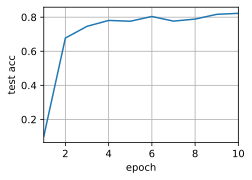

In [11]:
train(num_gpus=1, batch_size=256, lr=0.2)

Mantendo o tamanho do lote e a taxa de aprendizado inalterados e alterando o número de GPUs para 2, podemos ver que a melhoria na precisão do teste é aproximadamente a mesma que nos resultados do experimento anterior. Em termos de algoritmos de otimização, eles são idênticos. Infelizmente, não há aumento significativo a ser obtido aqui: o modelo é simplesmente muito pequeno; além disso, temos apenas um pequeno conjunto de dados, onde nossa abordagem um pouco menos sofisticada para implementar o treinamento multi-GPU sofreu com a sobrecarga significativa do Python. Encontraremos modelos mais complexos e formas mais sofisticadas de paralelização daqui para frente. Vamos ver o que acontece, no entanto, com o Fashion-MNIST.


test acc: 0.83, 2.4 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


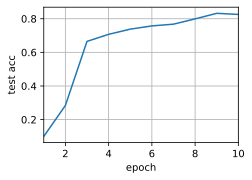

In [12]:
train(num_gpus=2, batch_size=256, lr=0.2)

## Resumo

* Existem várias maneiras de dividir o treinamento de rede profunda em várias GPUs. Podemos dividi-los entre camadas, entre camadas ou entre dados. Os dois primeiros requerem transferências de dados fortemente coreografadas. O paralelismo de dados é a estratégia mais simples.
* O treinamento paralelo de dados é direto. No entanto, aumenta o tamanho efetivo do minibatch para ser eficiente.
* Os dados são divididos em várias GPUs, cada GPU executa sua própria operação de avanço e retrocesso e, posteriormente, os gradientes são agregados e os resultados transmitidos de volta às GPUs.
* Minibatches grandes podem exigir uma taxa de aprendizado ligeiramente maior.

## Exercícios

1. Ao treinar em várias GPUs, altere o tamanho do minibatch de $b$ para $k \cdot b$, ou seja, aumente pelo número de GPUs.
1. Compare a precisão para diferentes taxas de aprendizagem. Como isso se dimensiona com o número de GPUs.
1. Implemente um `allreduce` mais eficiente que agregue diferentes parâmetros em diferentes GPUs (por que isso é mais eficiente em primeiro lugar).
1. Implementar cálculo de precisão de teste multi-GPU.


[Discussions](https://discuss.d2l.ai/t/1669)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMTcxMzI2MDM4NywtNDg2NzgzOTIyLC0xOD
QwMDUxNTU5XX0=
-->
